<center>
    <h1>CMSC320 Final Project</h1>
    Valentyn Bolotin, Jacob Barats, Evan May
</center>
<hr>

<center>
    <h3>Introduction</h3>
</center>

Since its creation, alcohol has been a staple in human society. Every country at some point in history has drunk alcohol and today most countries still do. The difference between then and now is the change in restrictions on alcohol. While few countries like Kuwait have <a href="https://www.latimes.com/world/middleeast/la-fg-kuwait-islamists-alcohol-20150105-story.html#:~:text=Kuwait%20and%20Saudi%20Arabia%20are,people%20convicted%20of%20drinking%20alcohol">absolute bans on alcohol</a>, many have regulations in place to limit the amount of alcohol consumption for their citizens. The exact reasoning for these restrictions change depending on the country but the general thought process is that when individuals consume less alcohol, they are better, more productive citizens. 

We want to challenge this reasoning by determining if a country's alcohol consumption impacts a country's gross domestic product (GDP). While a country's GDP is not a perfect reflection of the productivity of a country, there are enough correlation between the two that analysis can be conducted.

<hr>

<center>
    <h3>Data collection/curation</h3>
</center>
To determine if alcohol consumption impacts a country's GDP, we need to wrangle data for a country's alcohol consumption and GDP. The problem was that many of these datasets were incomplete or over a small time frame. Our solution was wrangling data from several sources and filling out as much missing information as possible. We have listed all the dataset that we use in this tutorial below.  

* Our World in Data
    * <a href = "https://ourworldindata.org/alcohol-consumption">Alochol Consumption per Capita</a>
    * <a href = "https://ourworldindata.org/grapher/gdp-world-regions-stacked-area?tab=table&time=earliest..1991&country=GRC~DEU~GHA~GTM~GNB~GIN~GMB~GAB~GNQ~GEO">Gross Domestic Product (GDP) based on 2011 International Dollar ($)</a>
    * <a href = "https://ourworldindata.org/grapher/alcohol-consumption-vs-gdp-per-capita">Alochol Consumption per Capita vs GDP per Capita based on Purchasing Power Partiry (PPP) </a>
<br> 
* University of Groningen, Maddison Project Database 2018
    * <a href = "https://www.rug.nl/ggdc/historicaldevelopment/maddison/releases/maddison-project-database-2018">GDP per capita based on 2011 US Dollar with and without multiple benchmarks, Total Population </a>
<br> 
* The World Bank, International Comparison Program (ICP)
    * <a href = "https://ourworldindata.org/alcohol-consumption">Purchasing Power Partiry (PPP)</a>
<br>
* World Health Organization
    * <a href = "https://www.who.int/data/gho/data/indicators/indicator-details/GHO/alcohol-recorded-per-capita-(15-)-consumption-(in-litres-of-pure-alcohol)">Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)</a>

<hr>

<center>
    <h3>Parsing and Data management</h3>
</center>
To complete the tutorial the following imports are required: Pandas, Numpy
<br>
The warnings import is just to avoid unncessary output and it will still run without it.

In [30]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from pandas.core.arrays import integer
from pandas.core.arrays.numeric import T
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
from scipy.spatial import ConvexHull
from scipy import interpolate
import math
import scipy.ndimage
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

<h4>Finding the Best Range</h4>

As stated previously, the data we aquired had large amounts of missing data. Many countries did not recorded data for various reasons meaning the datasets contain sections of time where there is little to no meaningful data. If we were to take all of the data and preform analysis on it, it would be be too skewed by the missing data to produce any meaningful results. Our decison was to determine the range of years that had the most data.

First we added the dataset from the Maddison Project Database. 

In [2]:
raw_data = pd.read_stata('Data/mpd2018.dta')
raw_df = pd.DataFrame(raw_data)
raw_df = raw_df.rename(columns= {"countrycode" : "code", "pop":"population",
                          "rgdpnapc":"gdp_pc_2011", "cgdppc":"gdp_pc_2011_mb"})
raw_df = raw_df.drop(columns=['i_cig', 'i_bm'])
combined_df = raw_df
combined_df

,code,country,year,gdp_pc_2011_mb,gdp_pc_2011,population
0,AFG,Afghanistan,1820.0,NaN,NaN,3280.0
1,AFG,Afghanistan,1870.0,NaN,NaN,4207.0
2,AFG,Afghanistan,1913.0,NaN,NaN,5730.0
3,AFG,Afghanistan,1950.0,2392.0,2392.0,8150.0
4,AFG,Afghanistan,1951.0,2422.0,2422.0,8284.0
...,...,...,...,...,...,...
19868,ZWE,Zimbabwe,2012.0,1623.0,1604.0,12620.0
19869,ZWE,Zimbabwe,2013.0,1801.0,1604.0,13183.0
19870,ZWE,Zimbabwe,2014.0,1797.0,1594.0,13772.0
19871,ZWE,Zimbabwe,2015.0,1759.0,1560.0,14230.0


(**DESCRIPTION OF HOW THIS WORKS**)
(**EXPLAIN MEANING OF OUTPUT**)
* Index :
* Year :
* absDvt : 
* dv_ser : 
* dt :
* adj_percent : 

In [3]:
codes_arr = []

for code in pd.unique(combined_df.code):
  if isinstance(code, str):
    codes_arr.append(code)
combined_df = combined_df[combined_df.code.isin(codes_arr)]

years_arr = np.sort(pd.unique(combined_df.year).reshape(-1))

years_num = {}

for year in years_arr:
  num_entries = len(combined_df[combined_df.year == year].index)
  years_num[year] = num_entries

for i in range(0, len(years_arr)):
  year = years_arr[i]
  prev_year = year
  if i > 0:
    prev_year = years_arr[i-1]
  delta_t = year - prev_year
  delta_v = 0
  delta_vt = 0
  if delta_t > 0:
    delta_v = (years_num[year] - years_num[prev_year][0])
    delta_vt = float(delta_v)/float(delta_t)
  years_num[year] = [years_num[year], years_num[year] - len(codes_arr), delta_t,
                     delta_v, delta_vt]

high_delta_indicies = []

start_year = years_arr[0]
high_delta_indicies.append([0, np.abs(years_num[start_year][4]), 0, 0, 
          1.0 + float(years_num[start_year][1])/float(len(codes_arr)),
          1])
hd_index = 0

for i in range(1, len(years_arr)):
  year = years_arr[i]
  curr_dvt = np.abs(years_num[year][4])
  curr_dt = years_num[year][2]
  curr_dv = years_num[year][3]
  if(curr_dvt > 0.2 * float(years_num[year][0])):
    hd_index = hd_index + 1
    high_delta_indicies.append([i, curr_dvt, 0, curr_dt,
      1.0 + float(years_num[year][1])/float(len(codes_arr)), 1])
  else:
    tmp = high_delta_indicies[hd_index]
    tmp[2] = tmp[2] + curr_dv
    tmp[3] = tmp[3] + curr_dt
    tmp[4] = tmp[4] + 1.0 + float(years_num[year][1])/float(len(codes_arr))
    tmp[5] = tmp[5] + 1
    high_delta_indicies[hd_index] = tmp

tmp = []
for elt in high_delta_indicies:
  if elt[5] > 1:
    tmp.append(elt)

high_delta_indicies = tmp

#our output
for elt in high_delta_indicies:
  to_print = "Index: {}, year: {}, absDvt: {}, dv_ser: {}, dt: {}, adj_percent: {}"
  to_print = to_print.format(elt[0], years_arr[elt[0]], elt[1], elt[2], elt[3],
                             elt[4]/elt[3])
print("Example of Output: ")                            
print(to_print)

Example of Output: 
Index: 674, year: 1950.0, absDvt: 103.0, dv_ser: 0, dt: 67.0, adj_percent: 1.0


Based on the analysis done we can now score each of the ranges and find the most suitable range to conduct our analysis on.

Using the information collected, we now can calculate the scores for each of the year ranges. 

In [4]:
##lets score all of our values
hd_scores = []

for elt in high_delta_indicies:
  score = 0
  ## % covered
  score += elt[4]/elt[3]
  ## ~time step
  time_step = elt[3]/elt[5]
  time_step_score = np.exp(-(time_step - 1))
  score += time_step_score
  ## total entries
  score += elt[5]/len(years_arr)
  ## delta trend
  dt_score = float(elt[2])/float(len(codes_arr))
  dt_score = dt_score * elt[4]/elt[3]
  dt_score = dt_score/2.0 + 0.5
  score += dt_score
  hd_scores.append(score)

max_index = np.argmax(hd_scores)

print("Best index: {}, score: {}, start_year: {}, end_year: {}".format(
  max_index, hd_scores[max_index], years_arr[high_delta_indicies[max_index][0]],
  years_arr[high_delta_indicies[max_index][0]] + high_delta_indicies[max_index][3]
  - years_num[years_arr[high_delta_indicies[max_index][0]]][2]
))

Best index: 27, score: 2.5904183535762484, start_year: 1950.0, end_year: 2016.0


For our tutorial we will use data from 1950 to 2016. This will make later analysis easier as there is a smaller likelihood of missing data. We can now remove the unnessesary rows from our dataframe, which is around 8000 rows. 

In [5]:
start_year = years_arr[high_delta_indicies[max_index][0]]
end_year = start_year + high_delta_indicies[max_index][3]

combined_df = combined_df[combined_df.year >= start_year]
combined_df = combined_df[combined_df.year <= end_year]

combined_df.head()

,code,country,year,gdp_pc_2011_mb,gdp_pc_2011,population
3,AFG,Afghanistan,1950.0,2392.0,2392.0,8150.0
4,AFG,Afghanistan,1951.0,2422.0,2422.0,8284.0
5,AFG,Afghanistan,1952.0,2462.0,2462.0,8425.0
6,AFG,Afghanistan,1953.0,2568.0,2568.0,8573.0
7,AFG,Afghanistan,1954.0,2576.0,2576.0,8728.0


<h4>Finding the missing values</h4>
While the range of years we have found has the least amount of missing entries, there is still a relative small amount in our data. In this tutorial we want to make sure that we have as much GDP data as possible. To fill in this data we will extract more data from the Our World in Data dataset.

In [6]:
cpc_df = pd.read_csv('Data/alcohol-consumption-vs-gdp-per-capita.csv')
cpc_df = pd.DataFrame(cpc_df)

cpc_df = cpc_df.drop(labels = "Continent", axis = 1)
cpc_df = cpc_df.rename(columns= {"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)" : "consumption_for_person",
                                 "GDP per capita, PPP (constant 2017 international $)" : "gdp_pc_2017", "Population (historical estimates)": "population_cpc",
                                 "Entity" : "country", "Code":"code", "Year":"year"})
cpc_df = cpc_df[cpc_df.code.isin(codes_arr)]
cpc_df["total_liters_consumed"] = cpc_df.consumption_for_person * cpc_df.population_cpc
cpc_df = cpc_df[cpc_df.year > start_year]
future_cpc_df = cpc_df[cpc_df.year > end_year]

cpc_df = cpc_df[cpc_df.year <= end_year]
cpc_df.gdp_pc_2017 = cpc_df.gdp_pc_2017
cpc_df.head()

,country,code,year,consumption_for_person,gdp_pc_2017,population_cpc,total_liters_consumed
1,Afghanistan,AFG,2010,0.21,1957.029070,29185511.0,6128957.31
2,Afghanistan,AFG,2015,0.21,2068.265904,34413603.0,7226856.63
4,Afghanistan,AFG,2002,NaN,1189.784668,22600774.0,NaN
5,Afghanistan,AFG,2003,NaN,1235.810063,23680871.0,NaN
6,Afghanistan,AFG,2004,NaN,1200.278013,24726689.0,NaN


We can search for missing entries in the main dataframe and attempt to fill it with the data in the new dataframe. The dataset from Our World in Data has data on total alcohol consumption per capita so we can add that to our main dataframe. Note that all missing entries from this point forward will be represented as -1.

In [7]:
hit_years_arr = np.sort(pd.unique(combined_df.year).reshape(-1))

temp_comb = combined_df

cpc_merge = cpc_df.drop(labels=["gdp_pc_2017","consumption_for_person", "population_cpc", "total_liters_consumed"],
                             axis = 1)

for code in codes_arr:
  cpc_code = cpc_merge[cpc_merge.code == code]
  combined_code = combined_df[combined_df.code == code]
  missing_years = np.array(hit_years_arr)
  sub_years = np.array(combined_code.year.to_numpy())
  missing_years = np.setdiff1d(missing_years, sub_years)
  
  if len(missing_years > 0):
    cpc_fill = cpc_code[cpc_code.year.isin(missing_years)]
    cpc_fill.index += len(temp_comb.index)
    temp_comb = pd.concat([temp_comb,cpc_fill])

cpc_merge = cpc_df.drop(labels = ["country"], axis = 1)
temp_comb = pd.merge(how = "left", left = temp_comb, right = cpc_merge, on=["code","year"])
temp_comb = temp_comb.fillna(-1)

combined_df = temp_comb
combined_df.head()

,code,country,year,gdp_pc_2011_mb,gdp_pc_2011,population,consumption_for_person,gdp_pc_2017,population_cpc,total_liters_consumed
0,AFG,Afghanistan,1950.0,2392.0,2392.0,8150.0,-1.0,-1.0,-1.0,-1.0
1,AFG,Afghanistan,1951.0,2422.0,2422.0,8284.0,-1.0,-1.0,7840151.0,-1.0
2,AFG,Afghanistan,1952.0,2462.0,2462.0,8425.0,-1.0,-1.0,7935996.0,-1.0
3,AFG,Afghanistan,1953.0,2568.0,2568.0,8573.0,-1.0,-1.0,8039684.0,-1.0
4,AFG,Afghanistan,1954.0,2576.0,2576.0,8728.0,-1.0,-1.0,8151316.0,-1.0


We only want data that has a low amount of missing entries. Data that is missing all of its population data isn't helpful so we remove them.

In [8]:
missing_codes = {}
for code in codes_arr:
  pop = combined_df[combined_df.code == code]
  pop = pop[((pop.population < 0) | (pop.population_cpc < 0))]
  pop_arr = []
  for i, row in pop.iterrows():
    pop_arr.append(row.year)
  missing_codes[code] = pop_arr

def code_comp (a):
  return -len(missing_codes[a])

sorted_codes = sorted(codes_arr, key=code_comp)

rem_codes = []
for code in sorted_codes:
  if len(missing_codes[code]) == end_year - start_year:
    rem_codes.append(code)

combined_df = combined_df[~combined_df.code.isin(rem_codes)]
hit_codes = pd.unique(combined_df.code).reshape(-1)
combined_df.head()

,code,country,year,gdp_pc_2011_mb,gdp_pc_2011,population,consumption_for_person,gdp_pc_2017,population_cpc,total_liters_consumed
0,AFG,Afghanistan,1950.0,2392.0,2392.0,8150.0,-1.0,-1.0,-1.0,-1.0
1,AFG,Afghanistan,1951.0,2422.0,2422.0,8284.0,-1.0,-1.0,7840151.0,-1.0
2,AFG,Afghanistan,1952.0,2462.0,2462.0,8425.0,-1.0,-1.0,7935996.0,-1.0
3,AFG,Afghanistan,1953.0,2568.0,2568.0,8573.0,-1.0,-1.0,8039684.0,-1.0
4,AFG,Afghanistan,1954.0,2576.0,2576.0,8728.0,-1.0,-1.0,8151316.0,-1.0


<h4>Additional tidying</h4>
We want to make sure that all of the data is in the same units. We change our population's scale to be one to one and make both our GDP columns be in terms of GDP per capita. This avoids problems of unit conversion in analysis later.

In [9]:
st_df = combined_df

st_df["population"] = st_df["population"] * 1000
st_df.population[st_df.population < 0] = -1

st_df["gdp_2011"] = st_df["gdp_pc_2011"] * st_df["population"]
st_df.gdp_2011[st_df.gdp_2011 < 0] = -1

st_df["gdp_2011_mb"] = st_df["gdp_pc_2011_mb"] * st_df["population"]
st_df.gdp_2011_mb[st_df.gdp_2011_mb < 0] = -1

st_df["gdp_2017"] = st_df["gdp_pc_2017"] * st_df["population_cpc"]
st_df.gdp_2017[st_df.gdp_2017 < 0] = -1

st_df["population"] = st_df["population"].astype(int)
st_df["population_cpc"] = st_df["population_cpc"].astype(int)
st_df["year"] = st_df["year"].astype(int)
st_df.head()

,code,country,year,gdp_pc_2011_mb,gdp_pc_2011,population,consumption_for_person,gdp_pc_2017,population_cpc,total_liters_consumed,gdp_2011,gdp_2011_mb,gdp_2017
0,AFG,Afghanistan,1950,2392.0,2392.0,8150000,-1.0,-1.0,-1,-1.0,1.949480e+10,1.949480e+10,1.0
1,AFG,Afghanistan,1951,2422.0,2422.0,8284000,-1.0,-1.0,7840151,-1.0,2.006385e+10,2.006385e+10,-1.0
2,AFG,Afghanistan,1952,2462.0,2462.0,8425000,-1.0,-1.0,7935996,-1.0,2.074235e+10,2.074235e+10,-1.0
3,AFG,Afghanistan,1953,2568.0,2568.0,8573000,-1.0,-1.0,8039684,-1.0,2.201546e+10,2.201546e+10,-1.0
4,AFG,Afghanistan,1954,2576.0,2576.0,8728000,-1.0,-1.0,8151316,-1.0,2.248333e+10,2.248333e+10,-1.0


The 2017 GDP that was added to our dataset is in terms of the constant 2017 internation dollar which is different than the 2011 GDP and the 2011 MB GDP. This causes issues when they are compared to one another in an analytical setting. Conversion factors are calculated for 2011 and 2016 are calculated for 2011, 2011 with multiple benchmarks, and 2017.

In [10]:
##Fill missing economic datapoints
##First find conversion factors

y1_df = combined_df[combined_df.year == 2011]
y2_df = combined_df[combined_df.year == 2016]
y1_vals = {"gdp_2011":0, "gdp_2011_mb":0, "gdp_2017":0}
y2_vals = {"gdp_2011":0, "gdp_2011_mb":0, "gdp_2017":0}
for code in hit_codes:
  c_df = y1_df[combined_df.code == code]
  for v in c_df["gdp_2011"]:
    y1_vals["gdp_2011"] = y1_vals["gdp_2011"] + v
  for v in c_df["gdp_2011_mb"]:
    y1_vals["gdp_2011_mb"] = y1_vals["gdp_2011_mb"] + v
  for v in c_df["gdp_2017"]:
    y1_vals["gdp_2017"] = y1_vals["gdp_2017"] + v
  c_df = y2_df[combined_df.code == code]
  for v in c_df["gdp_2011"]:
    y2_vals["gdp_2011"] = y2_vals["gdp_2011"] + v
  for v in c_df["gdp_2011_mb"]:
    y2_vals["gdp_2011_mb"] = y2_vals["gdp_2011_mb"] + v
  for v in c_df["gdp_2017"]:
    y2_vals["gdp_2017"] = y2_vals["gdp_2017"] + v

y1_vals["fac1"] = y1_vals["gdp_2011"] / y1_vals["gdp_2017"]
y1_vals["fac2"] = y1_vals["gdp_2011_mb"] / y1_vals["gdp_2017"]
y1_vals["fac2011"] = y1_vals["gdp_2011_mb"] / y1_vals["gdp_2011"]

y2_vals["fac1"] = y2_vals["gdp_2011"] / y2_vals["gdp_2017"]
y2_vals["fac2"] = y2_vals["gdp_2011_mb"] / y2_vals["gdp_2017"]
y2_vals["fac2011"] = y2_vals["gdp_2011_mb"] / y2_vals["gdp_2011"]

print(y1_vals)
print(y2_vals)

combined_df[combined_df.code == "USA"].head()

{'gdp_2011': 93952331058496.0, 'gdp_2011_mb': 93952331058496.0, 'gdp_2017': 98171539732185.94, 'fac1': 0.957022079054683, 'fac2': 0.957022079054683, 'fac2011': 1.0}
{'gdp_2011': 107295416080637.0, 'gdp_2011_mb': 106491490024125.0, 'gdp_2017': 115602680525130.58, 'fac1': 0.9281395171222896, 'fac2': 0.92118530072471, 'fac2011': 0.9925073587868114}


,code,country,year,gdp_pc_2011_mb,gdp_pc_2011,population,consumption_for_person,gdp_pc_2017,population_cpc,total_liters_consumed,gdp_2011,gdp_2011_mb,gdp_2017
10720,USA,United States,1950,15241.0,15241.0,152271008,-1.0,-1.0,-1,-1.0,2.320762e+12,2.320762e+12,1.0
10721,USA,United States,1951,16126.0,16126.0,154878000,-1.0,-1.0,160872264,-1.0,2.497563e+12,2.497563e+12,-1.0
10722,USA,United States,1952,16443.0,16443.0,157552992,-1.0,-1.0,163266026,-1.0,2.590644e+12,2.590644e+12,-1.0
10723,USA,United States,1953,16917.0,16917.0,160184000,-1.0,-1.0,165909996,-1.0,2.709833e+12,2.709833e+12,-1.0
10724,USA,United States,1954,16513.0,16513.0,163026000,-1.0,-1.0,168736390,-1.0,2.692048e+12,2.692048e+12,-1.0


<h4>Created the world dataset</h4>
We now have data for country and year but we want to make an easy access data that has the yearly sum for many of these columns such as GDP and total alcohol consumption. We create a world dataset to accomplish this.

In [11]:
world_df = pd.DataFrame(columns= combined_df.columns)
world_miss_df = pd.DataFrame(columns= world_df.columns).drop(labels = ["country", "code"], axis = 1)

common_attrs = ["population",
                "population_cpc",
                "consumption_for_person",
                "gdp_pc_2011_mb",
                "gdp_pc_2011",
                "gdp_pc_2017",
                "total_liters_consumed",
                "gdp_2011_mb",
                "gdp_2011",
                "gdp_2017"]

frac_attrs =   ["gdp_pc_2011_mb",
                "gdp_pc_2011",
                "gdp_pc_2017",
                "consumption_for_person"]

map_attrs =    {"gdp_pc_2011_mb" : "gdp_2011_mb",
                "gdp_pc_2011" : "gdp_2011",
                "gdp_pc_2017": "gdp_2017",
                "consumption_for_person" : "total_liters_consumed"}

for year in hit_years_arr:
  year_df = combined_df[combined_df.year == year]
  ser = pd.Series()
  ser["country"] = "WORLD"
  ser["code"] = "WORLD"
  ser["year"] = year

  ser_miss = pd.Series()
  ser_miss["year"] = year
  
  for attr in common_attrs:
    ser[attr] = 0
    ser_miss[attr] = []

  for i, row in year_df.iterrows():
    for attr in common_attrs:
      if row[attr] > 0:
        ser[attr] = row[attr] + ser[attr]
      else:
        ser_miss[attr].append(row["code"])

  for attr in common_attrs:
    if ser[attr] == 0:
      ser[attr] = -1

      
  # FIX FRAC ATTRS &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
  for attr in frac_attrs:
    if ser[attr] > 0:
      ser[attr] = ser[map_attrs[attr]] / ser["population"]
  world_df.loc[len(world_df.index)] = ser
  world_miss_df.loc[len(world_miss_df.index)] = ser_miss
  ##world_df = pd.concat([world_df,pd.Series(vs)], axis = 0, ignore_index = True)
  ##world_miss_df = pd.concat([world_miss_df,ser_miss], axis = 0)
world_df.head()

,code,country,year,gdp_pc_2011_mb,gdp_pc_2011,population,consumption_for_person,gdp_pc_2017,population_cpc,total_liters_consumed,gdp_2011,gdp_2011_mb,gdp_2017
0,WORLD,WORLD,1950.0,2840.316642,3193.007878,2514160984,-1,-1,-1,-1,8027735828641.0,7141013283921.0,166.0
1,WORLD,WORLD,1951.0,2985.611376,3355.141447,2557931000,-1,-1,2572198645,-1,8582220316169.0,7636987893105.0,-1
2,WORLD,WORLD,1952.0,3067.791124,3456.668876,2610876008,-1,-1,2618839562,-1,9024933836048.0,8009622243888.0,-1
3,WORLD,WORLD,1953.0,3191.232846,3591.33825,2658728016,-1,-1,2665387479,-1,9548391621048.0,8484620172448.0,-1
4,WORLD,WORLD,1954.0,3204.739537,3626.651794,2709558016,-1,-1,2712412149,-1,9826623440912.0,8683427700912.0,-1


Using this data we can but the fraction of the GDP, alcohol consumed, and population that a country represents for a given year. This is placed in the main dataframe.

In [12]:
comb_df = pd.concat([combined_df,world_df], ignore_index = True)

comb_df["frac_gdp_2011"] = -1
comb_df["frac_gdp_2011_mb"] = -1
comb_df["frac_gdp_2017"] = -1
comb_df["frac_liters_consumed"] = -1
comb_df["frac_population"] = -1
comb_df["frac_population_cpc"] = -1

for year in hit_years_arr:
  total = world_df[world_df.year == year].gdp_2011.to_numpy()[0]
  comb_df.frac_gdp_2011[comb_df.year == year] = comb_df.gdp_2011 / total

  total = world_df[world_df.year == year].gdp_2011_mb.to_numpy()[0]
  comb_df.frac_gdp_2011_mb[comb_df.year == year] = comb_df.gdp_2011_mb / total

  total = world_df[world_df.year == year].gdp_2017.to_numpy()[0]
  comb_df.frac_gdp_2017[comb_df.year == year] = comb_df.gdp_2017 / total

  total = world_df[world_df.year == year].total_liters_consumed.to_numpy()[0]
  comb_df.frac_liters_consumed[comb_df.year == year] = comb_df.total_liters_consumed / total

  total = world_df[world_df.year == year].population.to_numpy()[0]
  comb_df.frac_population[comb_df.year == year] = comb_df.population / total

  total = world_df[world_df.year == year].population_cpc.to_numpy()[0]
  comb_df.frac_population_cpc[comb_df.year == year] = comb_df.population_cpc / total

comb_df.frac_gdp_2011[comb_df["gdp_2011"] == -1] = -1
comb_df.frac_gdp_2011_mb[comb_df["gdp_2011_mb"] == -1] = -1
comb_df.frac_gdp_2017[comb_df["gdp_2017"] == -1] = -1
comb_df.frac_liters_consumed[comb_df["total_liters_consumed"] == -1] = -1
comb_df.frac_population[comb_df["population"] == -1] = -1
comb_df.frac_population_cpc[comb_df["population_cpc"] == -1] = -1

comb_df[comb_df.code == "USA"].head()

,code,country,year,gdp_pc_2011_mb,gdp_pc_2011,population,consumption_for_person,gdp_pc_2017,population_cpc,total_liters_consumed,gdp_2011,gdp_2011_mb,gdp_2017,frac_gdp_2011,frac_gdp_2011_mb,frac_gdp_2017,frac_liters_consumed,frac_population,frac_population_cpc
10586,USA,United States,1950,15241.0,15241.0,152271008,-1.0,-1.0,-1,-1.0,2320762404864.0,2320762404864.0,1.0,0.289093,0.324991,0.006024,-1,0.060565,-1
10587,USA,United States,1951,16126.0,16126.0,154878000,-1.0,-1.0,160872264,-1.0,2497562542080.0,2497562542080.0,-1.0,0.291016,0.327035,-1,-1,0.060548,0.062543
10588,USA,United States,1952,16443.0,16443.0,157552992,-1.0,-1.0,163266026,-1.0,2590643847168.0,2590643847168.0,-1.0,0.287054,0.323441,-1,-1,0.060345,0.062343
10589,USA,United States,1953,16917.0,16917.0,160184000,-1.0,-1.0,165909996,-1.0,2709832597504.0,2709832597504.0,-1.0,0.2838,0.319382,-1,-1,0.060248,0.062246
10590,USA,United States,1954,16513.0,16513.0,163026000,-1.0,-1.0,168736390,-1.0,2692048224256.0,2692048224256.0,-1.0,0.273955,0.310021,-1,-1,0.060167,0.062209


We now have the data for the GDP and overall alcohol consumption per year for each country and in terms of the world. For our tutorial we want the to compare the specific types of alcohol to one another. We import the dataset from the World Health Organization which has data about specific types of alcohol consumption by country. We remove the rows outside of our time range.

In [13]:
acp_df = pd.read_csv("Data/who-alcohol-per-cap.csv")
acp_df = pd.DataFrame(acp_df)

acp_df = acp_df.drop(labels= ["IndicatorCode","Indicator","ValueType","ParentLocationCode","ParentLocation", "Location type","Period type"], axis = 1)
acp_df = acp_df.rename(columns={"SpatialDimValueCode" : "code"})

filtered_acp_df = pd.DataFrame(columns= ["code", "year",
                                         "wine_mi", "wine_hi", "wine_lo",
                                         "beer_mi", "beer_hi", "beer_lo", 
                                         "spirits_mi", "spirits_hi", "spirits_lo", 
                                         "other_mi", "other_hi", "other_lo",
                                         "total_mi", "total_hi", "total_lo"])

for code in pd.unique(acp_df.code):
  c_df = acp_df[acp_df.code == code]
  for year in pd.unique(c_df.Period):
    y_df = c_df[c_df.Period == year]
    ser = pd.Series(index=filtered_acp_df.columns)
    ser["code"] = code
    ser["year"] = year
    got_ser = 0

    got_df = y_df[y_df["Dim1ValueCode"] == "SA_WINE"]
    if len(got_df.index > 0):
      got_ser = got_df.iloc[0]
      ser["wine_hi"] = got_ser["FactValueNumericHigh"]
      ser["wine_mi"] = got_ser["FactValueNumeric"]
      ser["wine_lo"] = got_ser["FactValueNumericLow"]

    got_df = y_df[y_df["Dim1ValueCode"] == "SA_BEER"]
    if len(got_df.index > 0):
      got_ser = got_df.iloc[0]
      ser["beer_hi"] = got_ser["FactValueNumericHigh"]
      ser["beer_mi"] = got_ser["FactValueNumeric"]
      ser["beer_lo"] = got_ser["FactValueNumericLow"]

    got_df = y_df[y_df["Dim1ValueCode"] == "SA_SPIRITS"]
    if len(got_df.index > 0):
      got_ser = got_df.iloc[0]
      ser["spirits_hi"] = got_ser["FactValueNumericHigh"]
      ser["spirits_mi"] = got_ser["FactValueNumeric"]
      ser["spirits_lo"] = got_ser["FactValueNumericLow"]

    got_df = y_df[y_df["Dim1ValueCode"] == "SA_OTHER_ALCOHOL"]
    if len(got_df.index > 0):
      got_ser = got_df.iloc[0]
      ser["other_hi"] = got_ser["FactValueNumericHigh"]
      ser["other_mi"] = got_ser["FactValueNumeric"]
      ser["other_lo"] = got_ser["FactValueNumericLow"]

    got_df = y_df[y_df["Dim1ValueCode"] == "SA_TOTAL"]
    if len(got_df.index > 0):
      got_ser = got_df.iloc[0]
      ser["total_hi"] = got_ser["FactValueNumericHigh"]
      ser["total_mi"] = got_ser["FactValueNumeric"]
      ser["total_lo"] = got_ser["FactValueNumericLow"]

    filtered_acp_df.loc[len(filtered_acp_df.index)] = ser

hit_acp_df = filtered_acp_df[filtered_acp_df.code.isin(hit_codes)]
hit_acp_df = hit_acp_df[hit_acp_df.year.isin(hit_years_arr)]

hit_acp_df = hit_acp_df.fillna(-1)
hit_acp_df.head()

,code,year,wine_mi,wine_hi,wine_lo,beer_mi,beer_hi,beer_lo,spirits_mi,spirits_hi,spirits_lo,other_mi,other_hi,other_lo,total_mi,total_hi,total_lo
3,AFG,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.014,0.006,0.00,0.000,0.000,0.01,0.014,0.006
4,AFG,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.00,0.000,0.000,0.00,0.000,0.000
5,AFG,2014,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.014,0.006,0.00,0.000,0.000,0.01,0.014,0.006
6,AFG,2013,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.01,0.014,0.006,0.01,0.014,0.006
7,AFG,2012,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.01,0.014,0.006,0.01,0.014,0.006


(**EXPLAIN SIGNIFICANCE OF DOING THIS**) (**EXPLAIN OUTPUT**)

In [14]:
miss_year = pd.DataFrame(columns=["year",
                                  "miss_wine", "miss_wine_range",
                                  "miss_beer", "miss_beer_range", 
                                  "miss_spirits", "miss_spirits_range", 
                                  "miss_other", "miss_other_range",
                                  "miss_total", "miss_total_range"])

##format-> series
##keys-> miss_beer
##keys-> miss_beer_range .. for all types

for year in hit_years_arr:
  year_df = hit_acp_df[hit_acp_df.year == year]
  if len(year_df.index) < 1:
    0==0
    ##miss_year[year] = -1
  else:
    offset = len(hit_codes) - len(year_df)
    ser = pd.Series(index = miss_year.columns)
    ser["miss_wine"] = len(year_df[year_df.wine_mi == -1].index) + offset
    ser["miss_wine_range"] = len(year_df[(year_df.wine_hi == -1) | (year_df.wine_lo == -1)].index) + offset
    ser["miss_beer"] = len(year_df[year_df.beer_mi == -1].index) + offset
    ser["miss_beer_range"] = len(year_df[(year_df.beer_hi == -1) | (year_df.beer_lo == -1)].index) + offset
    ser["miss_spirits"] = len(year_df[year_df.spirits_mi == -1].index) + offset
    ser["miss_spirits_range"] = len(year_df[(year_df.spirits_hi == -1) | (year_df.spirits_lo == -1)].index) + offset
    ser["miss_other"] = len(year_df[year_df.other_mi == -1].index) + offset
    ser["miss_other_range"] = len(year_df[(year_df.other_hi == -1) | (year_df.other_lo == -1)].index) + offset
    ser["miss_total"] = len(year_df[year_df.total_mi == -1].index) + offset
    ser["miss_total_range"] = len(year_df[(year_df.total_hi == -1) | (year_df.total_lo == -1)].index) + offset
    ser["year"] = year
    miss_year.loc[len(miss_year.index)] = ser


miss_year["score"] = 200 - (25 * miss_year['miss_beer']/len(hit_codes) +
                            5 * miss_year['miss_beer_range']/len(hit_codes) +
                            25 * miss_year['miss_wine']/len(hit_codes) + 
                            5 * miss_year['miss_wine_range']/len(hit_codes) + 
                            25 * miss_year['miss_spirits']/len(hit_codes) + 
                            5 * miss_year['miss_spirits_range']/len(hit_codes) + 
                            10 * miss_year['miss_other']/len(hit_codes) + 
                            5 * miss_year['miss_other_range']/len(hit_codes) + 
                            90 * miss_year['miss_total']/len(hit_codes) + 
                            5 * miss_year['miss_total_range']/len(hit_codes))

miss_year.head()

,year,miss_wine,miss_wine_range,miss_beer,miss_beer_range,miss_spirits,miss_spirits_range,miss_other,miss_other_range,miss_total,miss_total_range,score
0,1960.0,164.0,166.0,164.0,166.0,164.0,166.0,166.0,166.0,164.0,166.0,1.987952
1,1961.0,40.0,166.0,40.0,166.0,40.0,166.0,123.0,166.0,40.0,166.0,127.831325
2,1962.0,38.0,166.0,38.0,166.0,38.0,166.0,123.0,166.0,38.0,166.0,129.819277
3,1963.0,31.0,166.0,31.0,166.0,31.0,166.0,122.0,166.0,31.0,166.0,136.837349
4,1964.0,31.0,166.0,31.0,166.0,31.0,166.0,122.0,166.0,31.0,166.0,136.837349


We then extract the viable data entries and merge them to our main dataframe. The rows are merged if they have the same code and year.

In [15]:
viable_years = miss_year[miss_year.score > 180].year.to_numpy()
viable_acp_df = hit_acp_df[hit_acp_df.year.isin(viable_years)]
new_comb_df = pd.merge(how = "left", left = comb_df[comb_df.year.isin(viable_years)], right = viable_acp_df, on=["code","year"])
new_comb_df.head()

,code,country,year,gdp_pc_2011_mb,gdp_pc_2011,population,consumption_for_person,gdp_pc_2017,population_cpc,total_liters_consumed,...,beer_lo,spirits_mi,spirits_hi,spirits_lo,other_mi,other_hi,other_lo,total_mi,total_hi,total_lo
0,AFG,Afghanistan,2000,735.0,735.0,22461000,-1.0,-1.0,20779957,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,2001,692.0,692.0,22507000,-1.0,-1.0,21606992,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,Afghanistan,2002,1088.0,1088.0,23600000,-1.0,1189.784668,22600774,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AFG,Afghanistan,2003,1112.0,1112.0,25005000,-1.0,1235.810063,23680871,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AFG,Afghanistan,2004,1107.0,1107.0,25698000,-1.0,1200.278013,24726689,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Using the information from the from the <a href = "https://www.who.int/data/gho/data/indicators/indicator-details/GHO/alcohol-recorded-per-capita-(15-)-consumption-(in-litres-of-pure-alcohol)">World Health Organization</a>, we can calculate values of volume per type of alcohol consumed. For our purposes the average for wine, beer, spirits, and other were taken to use against the data collected in the previous section.

In [16]:
# From the World Health Organization
wine_abv = [0.12,0.09,0.16]
beer_abv = [0.05]
spirits_abv = [0.4,0.3]
other_abv = [0.05,0.05,0.17,0.18,0.09,0.09,0.09]

wine_abv = np.mean(wine_abv)
beer_abv = np.mean(beer_abv)
spirits_abv = np.mean(spirits_abv)
other_abv = np.mean(other_abv)

new_comb_df["wine_mi_vol"] = new_comb_df["wine_mi"] / wine_abv
new_comb_df["wine_hi_vol"] = new_comb_df["wine_hi"] / wine_abv
new_comb_df["wine_lo_vol"] = new_comb_df["wine_lo"] / wine_abv
new_comb_df["beer_mi_vol"] = new_comb_df["beer_mi"] / beer_abv
new_comb_df["beer_hi_vol"] = new_comb_df["beer_hi"] / beer_abv
new_comb_df["beer_lo_vol"] = new_comb_df["beer_lo"] / beer_abv
new_comb_df["spirits_mi_vol"] = new_comb_df["spirits_mi"] / spirits_abv
new_comb_df["spirits_hi_vol"] = new_comb_df["spirits_hi"] / spirits_abv
new_comb_df["spirits_lo_vol"] = new_comb_df["spirits_lo"] / spirits_abv
new_comb_df["other_mi_vol"] = new_comb_df["other_mi"] / other_abv
new_comb_df["other_hi_vol"] = new_comb_df["other_hi"] / other_abv
new_comb_df["other_lo_vol"] = new_comb_df["other_lo"] / other_abv

new_comb_df["total_mi_vol"] = new_comb_df["wine_mi_vol"] + new_comb_df["beer_mi_vol"] + new_comb_df["spirits_mi_vol"] + new_comb_df["other_mi_vol"]
new_comb_df["total_hi_vol"] = new_comb_df["wine_hi_vol"] + new_comb_df["beer_hi_vol"] + new_comb_df["spirits_hi_vol"] + new_comb_df["other_hi_vol"]
new_comb_df["total_lo_vol"] = new_comb_df["wine_lo_vol"] + new_comb_df["beer_lo_vol"] + new_comb_df["spirits_lo_vol"] + new_comb_df["other_lo_vol"]

new_comb_df["consumption_for_person"][new_comb_df.consumption_for_person < 0] = new_comb_df["total_mi"]
new_comb_df["fluid_vol_mi"] = new_comb_df["total_mi_vol"] * new_comb_df["population"]
new_comb_df["vol_vs_pure_mi"] = new_comb_df["total_mi"] / new_comb_df["total_mi_vol"]
new_comb_df[new_comb_df.code == "USA"].head()

,code,country,year,gdp_pc_2011_mb,gdp_pc_2011,population,consumption_for_person,gdp_pc_2017,population_cpc,total_liters_consumed,...,spirits_hi_vol,spirits_lo_vol,other_mi_vol,other_hi_vol,other_lo_vol,total_mi_vol,total_hi_vol,total_lo_vol,fluid_vol_mi,vol_vs_pure_mi
2686,USA,United States,2000,45887.0,45887.0,282737984,9.19,50124.891177,281710914,2588923299.66,...,9.600000,4.085714,0.0,0.0,0.0,108.800772,150.572973,66.161390,30762110989.689571,0.075459
2687,USA,United States,2001,45878.0,45878.0,285550016,8.25,50126.720222,284607992,-1.0,...,9.771429,4.400000,0.0,0.0,0.0,109.600772,154.268726,66.637838,31296502255.542858,0.075273
2688,USA,United States,2002,46267.0,46267.0,288212000,8.33,50528.788577,287279312,-1.0,...,9.600000,4.114286,0.0,0.0,0.0,110.249421,153.908108,67.514286,31775206081.853279,0.075556
2689,USA,United States,2003,47158.0,47158.0,290700000,8.4,51529.726404,289815567,-1.0,...,10.114286,4.485714,0.0,0.0,0.0,109.316602,150.265637,68.610039,31778336293.436287,0.076841
2690,USA,United States,2004,48493.0,48493.0,293401984,8.48,52994.55196,292354663,-1.0,...,10.400000,4.514286,0.0,0.0,0.0,109.645560,150.081081,67.719691,32170224795.477993,0.077340


<hr>

<center>
    <h3>Exploratory data analysis</h3>
</center>
<ol>
    <li>How did we want to display the data</li>
    <li>Code of displaying data</li>
    <li>Graphs/Charts of displayed data</li>
    </ol>
There will be multiple groups of these three sections
<hr>


To show a relationship between the GDP and alcohol consumption, we graph the median consumption per person and the logrithmically scalled gdp per capita. 

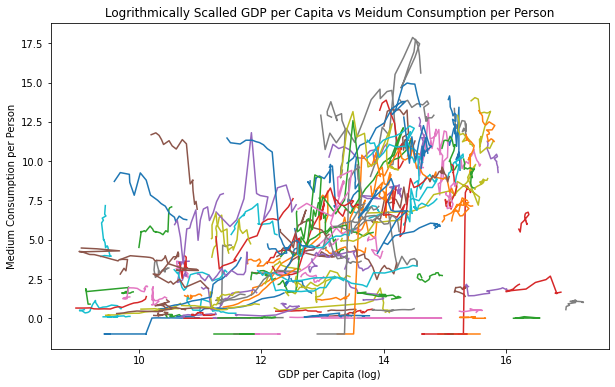

In [17]:
plt.figure(figsize=[10,6])
plt.title("Logrithmically Scalled GDP per Capita vs Meidum Consumption per Person")
plt.xlabel("GDP per Capita (log)")
plt.ylabel("Medium Consumption per Person")
for code in hit_codes:
  plottable = new_comb_df.fillna(-1)[new_comb_df.code == code]
  plottable = plottable[plottable.population != -1]
  plot_gdp = []
  plot_medcon = []
  for i, row in plottable.iterrows():
    plot_gdp.append(np.log2(row.gdp_pc_2011))
    plot_medcon.append(row.total_mi)
  plt.plot(plot_gdp, plot_medcon)


Each line on the graph represents a country in our data. Looking at this data we can see a vauge pattern in the data. The data becomes much more clear when you create the same graph but over time.

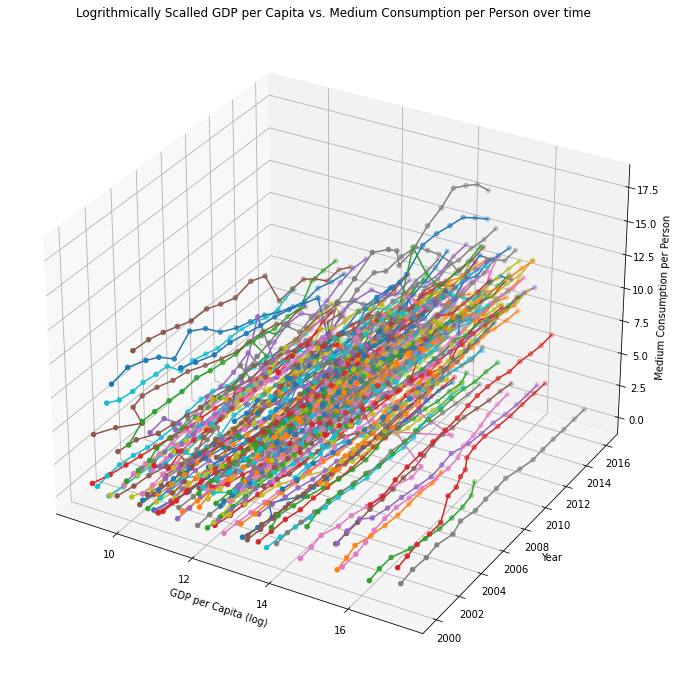

In [18]:
fig = plt.figure(figsize=(20,12))
ax = plt.axes(projection='3d')

new_comb_df = new_comb_df.fillna(-1)

ax.set_xlabel('GDP per Capita (log)')
ax.set_ylabel('Year')
ax.set_zlabel('Medium Consumption per Person');
ax.title.set_text("Logrithmically Scalled GDP per Capita vs. Medium Consumption per Person over time")
all_pts = []
all_x = []
all_y = []
all_z = []
for code in hit_codes:
  x = []
  y = []
  z = []
  code_df = new_comb_df[new_comb_df.code == code]
  for year in pd.unique(new_comb_df.year):
    y_df = code_df[code_df.year == year]
    xvar = np.log2(y_df["gdp_pc_2011"].to_numpy()[0])
    yvar = year
    zvar = y_df["total_mi"].to_numpy()[0]
    if xvar > 0 and yvar > 0 and zvar > 0:
      x.append(xvar)
      y.append(yvar)
      z.append(zvar)
      all_pts.append([xvar,yvar,zvar])
      all_x.append(xvar)
      all_y.append(yvar)
      all_z.append(zvar)
  ax.plot3D(x,y,z)
  ax.scatter3D(x,y,z)

(**WHAT DOES THIS SHOW US**)

In [19]:
def _gaussian_kernel1d(sigma, order, radius):
    """
    Computes a 1-D Gaussian convolution kernel.
    """
    if order < 0:
        raise ValueError('order must be non-negative')
    exponent_range = np.arange(order + 1)
    sigma2 = sigma * sigma
    x = np.arange(-radius, radius+1)
    phi_x = np.exp(-0.5 / sigma2 * x ** 2)
    phi_x = phi_x / phi_x.sum()

    if order == 0:
        return phi_x
    else:
        # f(x) = q(x) * phi(x) = q(x) * exp(p(x))
        # f'(x) = (q'(x) + q(x) * p'(x)) * phi(x)
        # p'(x) = -1 / sigma ** 2
        # Implement q'(x) + q(x) * p'(x) as a matrix operator and apply to the
        # coefficients of q(x)
        q = np.zeros(order + 1)
        q[0] = 1
        D = np.diag(exponent_range[1:], 1)  # D @ q(x) = q'(x)
        P = np.diag(np.ones(order)/-sigma2, -1)  # P @ q(x) = q(x) * p'(x)
        Q_deriv = D + P
        for _ in range(order):
            q = Q_deriv.dot(q)
        q = (x[:, None] ** exponent_range).dot(q)
        return q * phi_x

In [20]:
def make_surf_plot_points(pts, step, smooth_fac, f, sigma = 100, truncate = 4.0, add_x_bound = (0,0), add_y_bound = (0,0), blur_iter = 1, smooth_kind = 2, adj_blur = True):
  order = 0
  x_min = np.Infinity
  x_max = -np.Infinity
  y_min = np.Infinity
  y_max = -np.Infinity

  for pt in pts:
    x = pt[0]
    y = pt[1]
    if x < x_min:
      x_min = x
    elif x > x_max:
      x_max = x
    if y < y_min:
      y_min = y
    elif y > y_max:
      y_max = y
    
  x_add = (add_x_bound[0] + add_x_bound[1])/((x_max - x_min)/step)
  y_add = (add_y_bound[0] + add_y_bound[1])/((y_max - y_min)/step)

  x_max = x_max + add_x_bound[1]
  x_min = x_min - add_x_bound[0]
  y_max = y_max + add_y_bound[1]
  y_min = y_min - add_y_bound[0]

  step = step + math.ceil(np.max([x_add, y_add]))

  x_arr = np.linspace(x_min,x_max,step)
  y_arr = np.linspace(y_min,y_max,step)
  X,Y = np.meshgrid(x_arr,y_arr)

  Z_grid = [[0.0]*step]*step
  Z_grid = np.array(Z_grid)
  fac_x = 1/(x_max-x_min)*step
  fac_y = 1/(y_max-y_min)*step

  for pt in all_pts:
    x = int((pt[0] - x_min) * fac_x)
    y = int((pt[1] - y_min) * fac_y)
    if x == step:
      x = x - 1
    if y == step:
      y = y - 1
    z = pt[2]
    curr = Z_grid[x][y]
    Z_grid[x][y] = f(z, curr)

  Z_grid = np.transpose(Z_grid)

  if smooth_fac > 1:
    x_arr = np.linspace(x_min, x_max, num = int(step * smooth_fac))
    y_arr = np.linspace(y_min, y_max, num = int(step * smooth_fac))
    x_new,y_new = np.meshgrid(x_arr,y_arr)

    init_arr = []
    for i in range(0,step):
      for j in range(0,step):
        init_arr.append([int(i * smooth_fac),
                         int(j * smooth_fac),
                         Z_grid[i,j]])
        
    Z_grid = scipy.ndimage.zoom(Z_grid, smooth_fac, order=smooth_kind)
    Z_grid = np.clip(Z_grid, a_min = 0, a_max = np.Infinity)

    X = x_new
    Y = y_new

  b_i = blur_iter
  while b_i > 0:


    if adj_blur:

      max_lw = int(smooth_fac) - 1

      if truncate > max_lw / (sigma - 0.5):
        truncate = 4
        print("truncate exeeded maximum for resolution, new truncate = ", truncate)
      if sigma > max_lw / (truncate - 0.5):
        sigma = (max_lw - 0.5) / truncate
        print("sigma exeeded maximum for resolution, new sigma = ", sigma)

      lw = int(truncate * float(sigma) + 0.5)
      kern = _gaussian_kernel1d(sigma= sigma, order= order, radius= lw)
      kernb = np.reshape(kern,(-1,1))

      print(lw)

      keep_vals = []

      Z_rast = np.zeros((step * smooth_fac,step * smooth_fac))

      for i in range(0,step):
        for j in range(0,step):
          keep_vals.append([int(i * smooth_fac),int(j * smooth_fac)])
      r = 2*lw
      Z_grid = Z_rast
      

    else:
      Z_grid = scipy.ndimage.gaussian_filter(Z_grid, sigma=sigma, mode="mirror") 
      Z_grid = np.clip(Z_grid, a_min = 0, a_max = np.Infinity)
    b_i = b_i - 1

  return X,Y,Z_grid

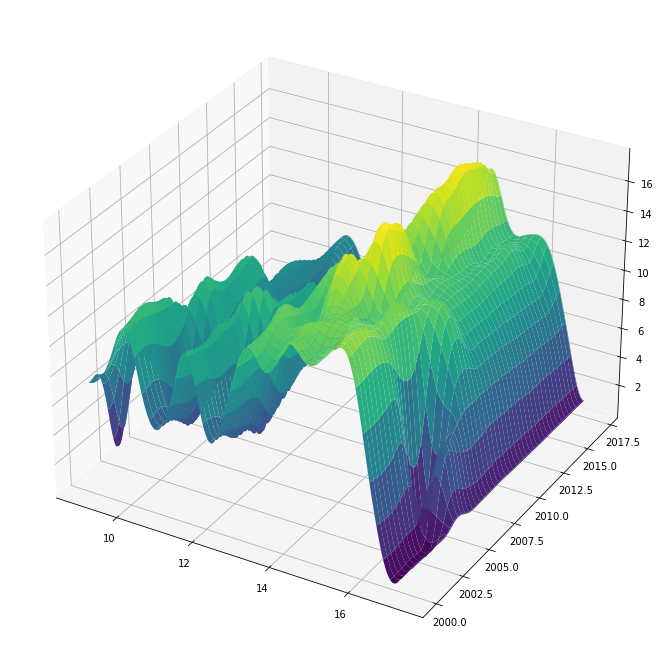

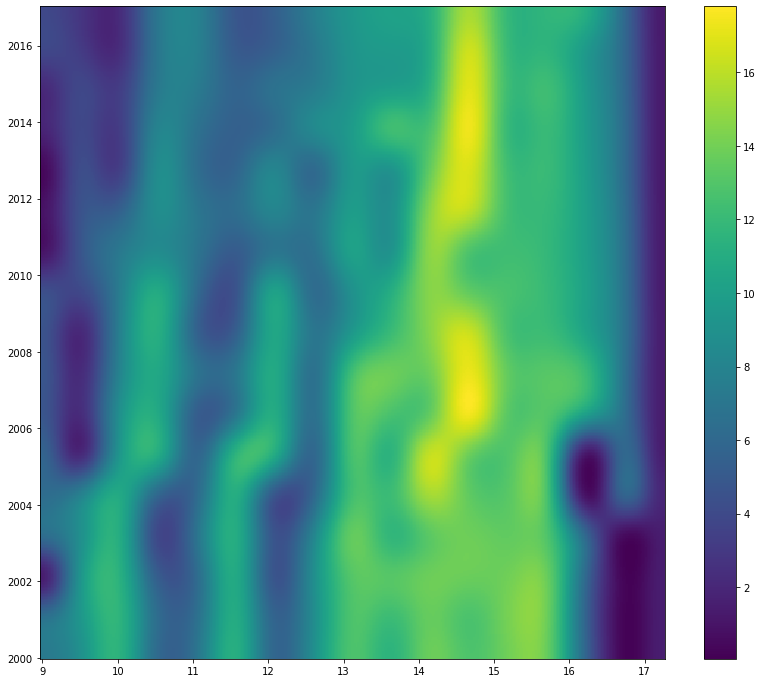

In [21]:
##maximum datapoints mapping log2(gdp_pc_2011) and average abv to total alcohol consumption, 2d interpolation and gauss blur smoothing
fig = plt.figure(figsize=(20,12))
ax = fig.gca(projection='3d')

x_test , y_test, z_max = make_surf_plot_points(all_pts, 16, 25, lambda x,y : np.max([x,y]), sigma=5, add_y_bound=(0,1), blur_iter = 1, adj_blur = False, smooth_kind=2)

ax.plot_surface(x_test, y_test, z_max, cmap='viridis')
plt.show()

# Top down of the graph
fig = plt.figure(figsize=(14,12))
ax = plt.axes()
c = ax.pcolormesh(x_test, y_test, z_max, cmap='viridis', vmin=np.min(z_max), vmax=np.max(z_max))

fig.colorbar(c, ax=ax)
plt.show()

(**EXPLANATION OF THESE GRAPHS**)

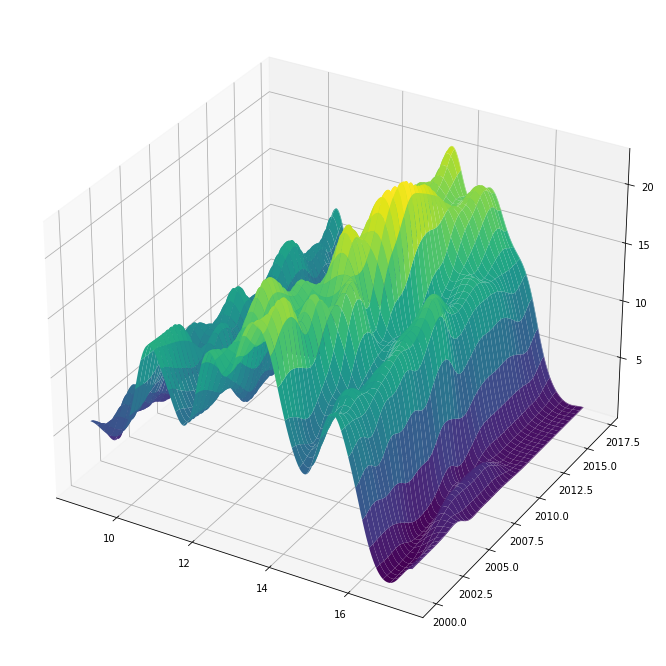

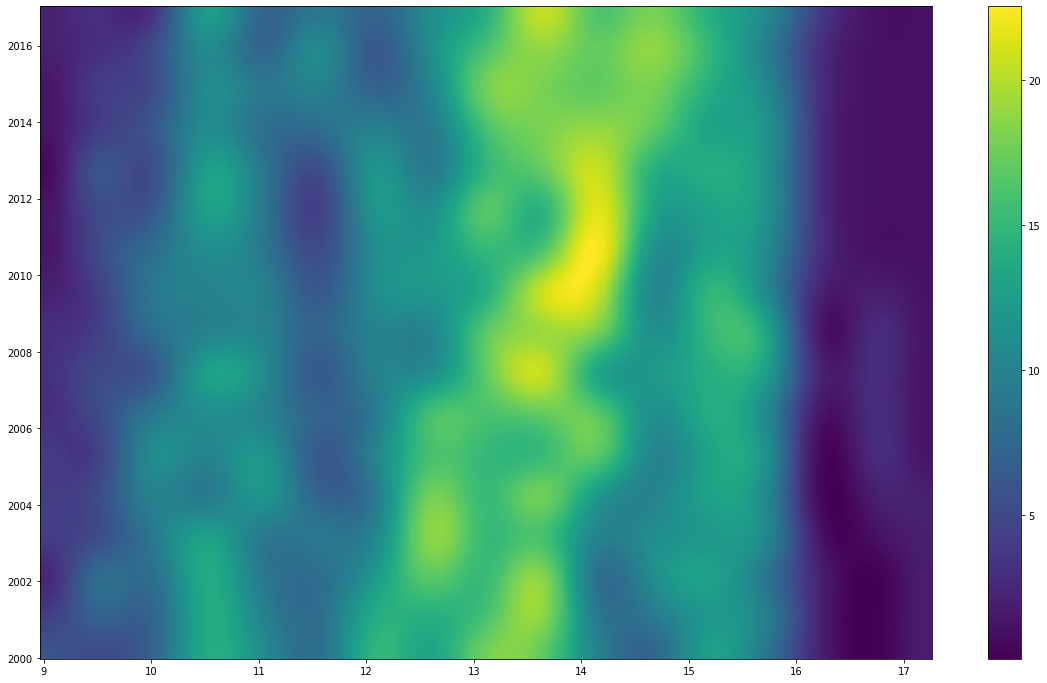

In [22]:
##density of datapoints mapping log2(gdp_pc_2011) and average abv to total alcohol consumption, 2d interpolation and gauss blur smoothing

fig = plt.figure(figsize=(20,12))
ax = fig.gca(projection='3d')

x_test , y_test, z_tot = make_surf_plot_points(all_pts, 16, 25, lambda x,y : y + 1, sigma=5, add_y_bound=(0,1), blur_iter = 1, adj_blur = False, smooth_kind=2)

ax.plot_surface(x_test, y_test, z_tot, cmap='viridis')
plt.show()

fig = plt.figure(figsize=(20,12))
ax = plt.axes()

c = ax.pcolormesh(x_test, y_test, z_tot, cmap='viridis', vmin=np.min(z_tot), vmax=np.max(z_tot))


fig.colorbar(c, ax=ax)
plt.show()


(**EXPLANATION OF GRAPHS**)

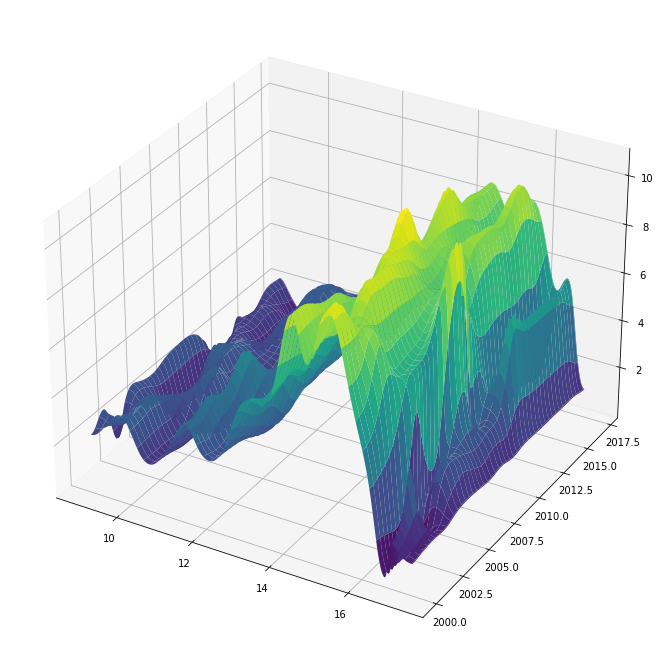

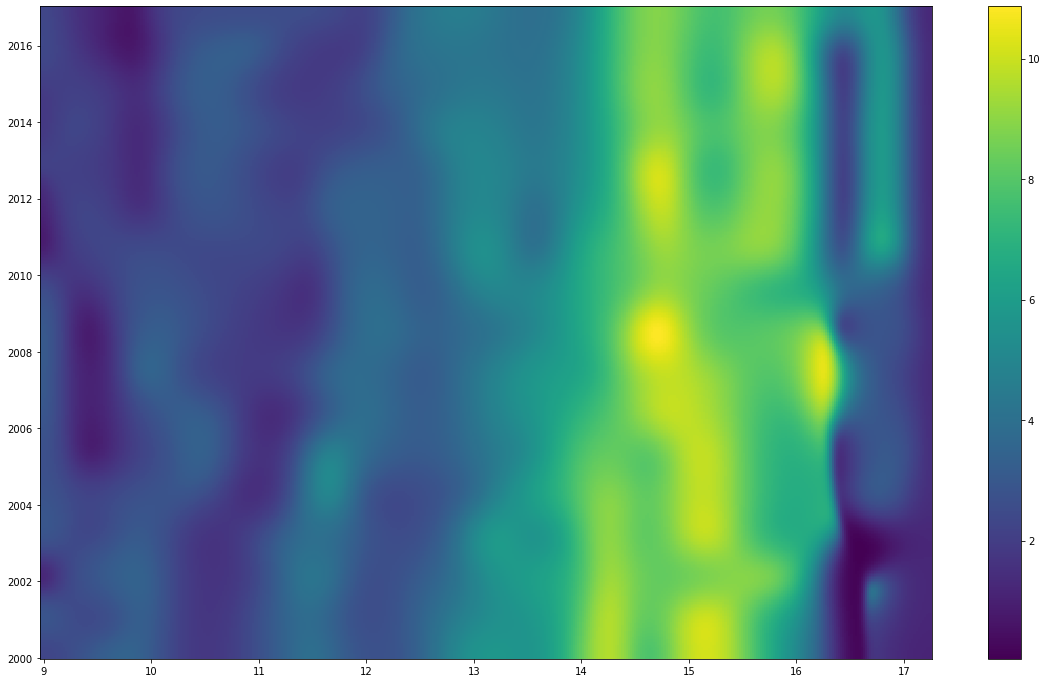

In [23]:
##avg of datapoints mapping log2(gdp_pc_2011) and average abv over time, 2d interpolation and gauss blur smoothing
fig = plt.figure(figsize=(20,12))
ax = fig.gca(projection='3d')

x_test , y_test, z_test = make_surf_plot_points(all_pts, 16, 25, lambda x,y : x+y, sigma=5, add_y_bound=(0,1), blur_iter = 1, adj_blur = False, smooth_kind=2)
z_test = z_test / z_tot
ax.plot_surface(x_test, y_test, z_test, cmap='viridis')
plt.show()

##top down view of previous graph
fig = plt.figure(figsize=(20,12))
ax = plt.axes()

c = ax.pcolormesh(x_test, y_test, z_test, cmap='viridis', vmin=np.min(z_test), vmax=np.max(z_test))

fig.colorbar(c, ax=ax)
plt.show()

(**EXPLANATION OF GRPAH**)

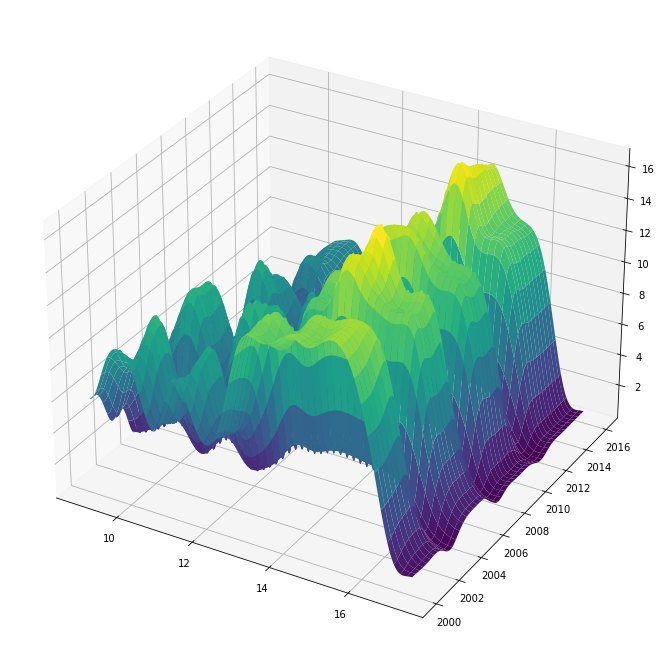

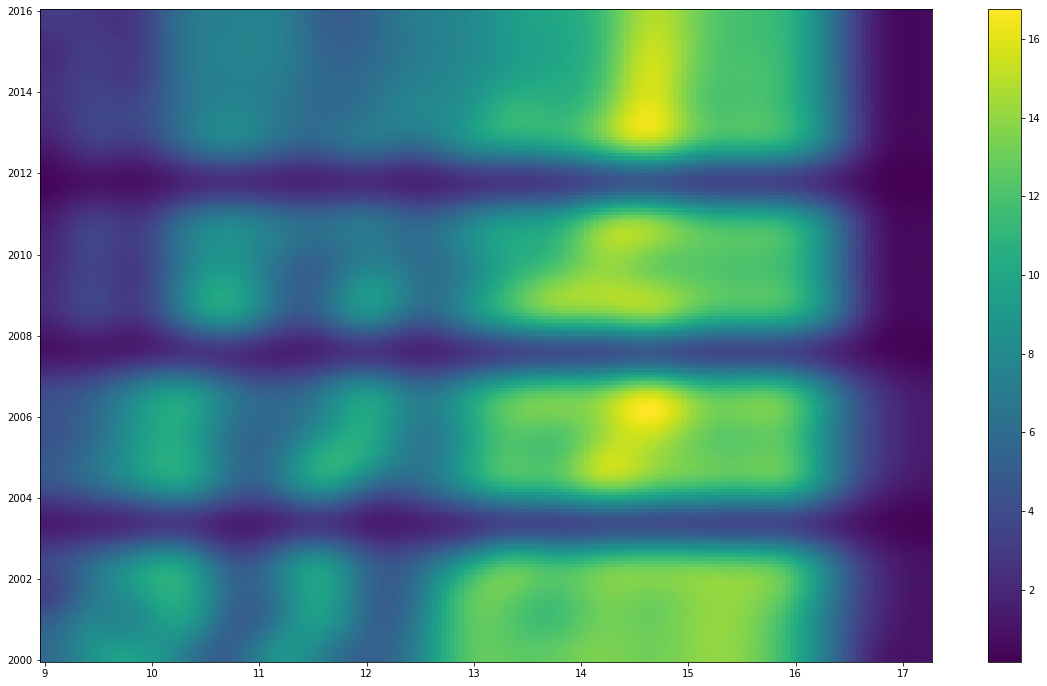

In [24]:
##maximum datapoints mapping log2(gdp_pc_2011) and average abv to total alcohol consumption, 2d interpolation and gauss blur smoothing

fig = plt.figure(figsize=(20,12))
ax = fig.gca(projection='3d')


x_test , y_test, z_test = make_surf_plot_points(all_pts, 20, 10, lambda x,y : np.max([x,y]), sigma=5, blur_iter = 1, adj_blur = False, smooth_kind=2)

ax.plot_surface(x_test, y_test, z_test, cmap='viridis')
plt.show()

##top down view of previous graph
fig = plt.figure(figsize=(20,12))
ax = plt.axes()

c = ax.pcolormesh(x_test, y_test, z_test, cmap='viridis', vmin=np.min(z_test), vmax=np.max(z_test))


fig.colorbar(c, ax=ax)
plt.show()

<center>
    <h3>Hypothesis testing</h3>
</center>



Before we can do an analysis of the relation between GDP and alchohol consumption, we must first take care of our missing values. To do so we use a K-nearest neighbor approach.

In [25]:
#this dataframe will contain all missing values
filled_df = new_comb_df[['code','year','gdp_pc_2011_mb','population','wine_mi','beer_mi','spirits_mi','other_mi']]
filled_df = filled_df.replace(-1,np.nan)
filled_df

consumption_imputer = filled_df

#when working with a knn model we can't process string data, so we change coutry codes to numeric values
le = preprocessing.LabelEncoder()
le.fit(consumption_imputer['code'])
consumption_imputer['code'] = le.transform(consumption_imputer['code'])
consumption_imputer

#in order to allow distance functions to work for k nearest neighbors, we change all values to be normalized between 0 and 1
scaler = preprocessing.MinMaxScaler()
consumption_imputer = pd.DataFrame(scaler.fit_transform(consumption_imputer), columns=consumption_imputer.columns)

consumption_imputer_na = consumption_imputer
consumption_imputer = filled_df.dropna()
consumption_imputer

,code,year,gdp_pc_2011_mb,population,wine_mi,beer_mi,spirits_mi,other_mi
5,0,2005.0,1187.0,26335000,0.0008,0.009,0.006,0.00
6,0,2006.0,1257.0,27154000,0.0080,0.011,0.007,0.00
7,0,2007.0,1447.0,27387000,0.0090,0.007,0.002,0.00
8,0,2008.0,1464.0,27706000,0.0009,0.009,0.018,0.00
9,0,2009.0,1669.0,28484000,0.0000,0.010,0.000,0.00
...,...,...,...,...,...,...,...,...
2817,166,2012.0,1623.0,12620000,0.0500,2.070,0.470,1.34
2818,166,2013.0,1801.0,13183000,0.0500,2.120,0.470,1.47
2819,166,2014.0,1797.0,13772000,0.0600,2.230,0.360,1.57
2820,166,2015.0,1759.0,14230000,0.0600,1.930,0.360,1.49


In [27]:
fields_to_fill = ['wine_mi','beer_mi','spirits_mi','other_mi']

X = consumption_imputer[consumption_imputer[fields_to_fill[0]] >= 0][['year','gdp_pc_2011_mb','population']]
Y = consumption_imputer[consumption_imputer[fields_to_fill[0]] >= 0][fields_to_fill[0]]

x_train, x_test, y_train, y_test = train_test_split(X,Y,train_size=0.7)
#now we can begin the actual imputing

Text(0.5, 1.0, 'detecting ideal k')

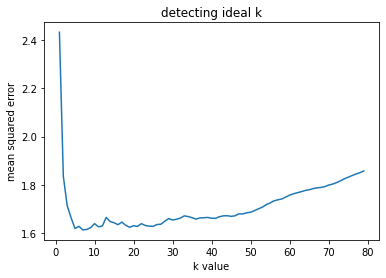

In [31]:
fig, ax = plt.subplots()
num_k = np.arange(1,80,1)
accuracy = {} #records the accuracy of each neighbor setting

#builds model for each differernt neighbor number
for neighbors in num_k:
  knn = KNeighborsRegressor(n_neighbors=neighbors)
  model = knn.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  mse = mean_squared_error(y_test,y_pred)
  accuracy[neighbors] = mse


plotable_x = np.fromiter(accuracy.keys(), dtype=float)
plotable_y = np.fromiter(accuracy.values(), dtype=float)
ax.plot(plotable_x,plotable_y)
ax.set_xlabel('k value')
ax.set_ylabel('mean squared error')
ax.set_title('detecting ideal k')

In [32]:
consumption_imputer_na = filled_df.fillna(-1)

def fillField(field):

  X = consumption_imputer[consumption_imputer[field] >= 0][['year','gdp_pc_2011_mb','population']]
  Y = consumption_imputer[consumption_imputer[field] >= 0][field]
  x_train, x_test, y_train, y_test = train_test_split(X,Y,train_size=0.7)

  ideal_k = min(accuracy, key=accuracy.get) #this k value produced the least amount of error so we will use it!
  knn = KNeighborsRegressor(n_neighbors=ideal_k)
  model = knn.fit(x_train, y_train) #we now have the actual interpolation model that we wish to use

  

  cond = (consumption_imputer_na[field] == -1)
  x_operate = consumption_imputer_na[cond][['year','gdp_pc_2011_mb','population']]
  x_operate
  mystery_vals = model.predict(x_operate)

  ##print(x_operate)
  # print(mystery_vals)

  index_map = []
  j = 0
  for i, x in x_operate.iterrows():
    index_map.append(i)
    j = j + 1

  ##consumption_imputer_na.iloc[index_map]['wine_mi'] = mystery_vals##.replace(to_replace=-1,value=mystery_vals)
  ##consumption_imputer_na.merge(right= mystery_vals, left_index= True, right_index= True)
  ##consumption_imputer_na.iloc[index_map]["wine_mi"] = index_map
  consumption_imputer_na.iloc[index_map, consumption_imputer_na.columns.get_loc(field)] = mystery_vals
  consumption_imputer_na.iloc[index_map]

#runs through all different fields
consumption_imputer_na['total_consumption'] = 0
for field in fields_to_fill:
  fillField(field)
  consumption_imputer_na['total_consumption'] = consumption_imputer_na['total_consumption'] + consumption_imputer_na[field]


consumption_imputer_na['code'] = le.inverse_transform(consumption_imputer_na['code'])
# consumption_imputer_na['total_consumption'] = consumption_imputer_na[]
# consumption_imputer.rename(columns={'gdp_pc_2011_mb': 'gdp'})
data_analysis = consumption_imputer_na
data_analysis

,code,year,gdp_pc_2011_mb,population,wine_mi,beer_mi,spirits_mi,other_mi,total_consumption
0,AFG,2000.0,735.000000,22461000,1.120000,1.279286,1.537857,0.585714,4.522857
1,AFG,2001.0,692.000000,22507000,1.110000,1.286429,1.537857,0.217143,4.151429
2,AFG,2002.0,1088.000000,23600000,0.084857,1.916286,0.970714,0.137143,3.109000
3,AFG,2003.0,1112.000000,25005000,0.015114,0.724000,1.246286,1.709529,3.694929
4,AFG,2004.0,1107.000000,25698000,0.093857,1.109000,1.049571,1.578986,3.831414
...,...,...,...,...,...,...,...,...,...
2834,WORLD,2012.0,13815.576851,6992922992,0.188571,1.552857,3.457143,0.000171,5.198743
2835,WORLD,2013.0,14030.044051,7072213016,0.188571,1.552857,3.457143,0.000171,5.198743
2836,WORLD,2014.0,14261.271531,7152269064,0.188571,1.552857,3.457143,0.000171,5.198743
2837,WORLD,2015.0,14493.906019,7231374064,0.188571,1.552857,3.457143,0.000171,5.198743


Now with our imputed alchohol consumption metrics, we can begin to search for potential correlations.

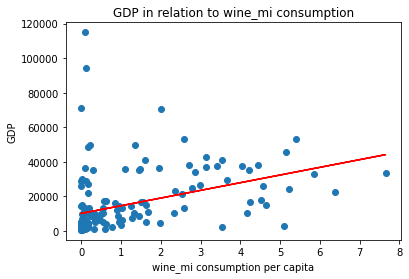

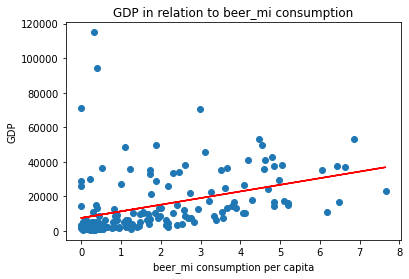

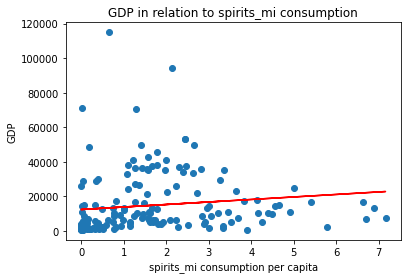

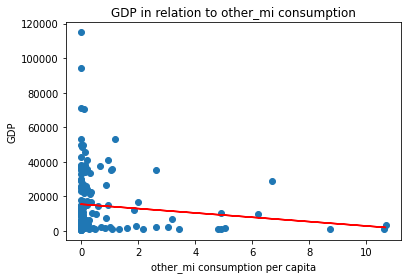

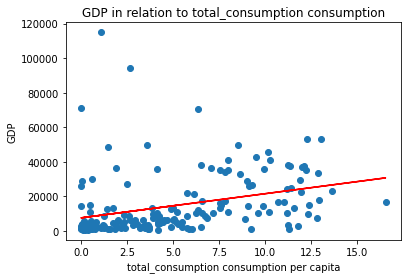

In [33]:
# GDP to total alchohol consumption

fields = ['wine_mi','beer_mi','spirits_mi','other_mi','total_consumption']

#first condition sets the year
cond = (data_analysis['year'] == 2005)
yearFocus = data_analysis.loc[cond,:]

figures = []
for field in fields:
    fig, ax = plt.subplots()
    figures.append((fig,ax))

for i, field in enumerate(fields):
    m, b = np.polyfit(yearFocus[field],yearFocus['gdp_pc_2011_mb'],1)
    figures[i][1].plot(yearFocus[field],m*yearFocus[field]+b,color='red')
    figures[i][1].scatter(yearFocus[field],yearFocus['gdp_pc_2011_mb'])
    figures[i][1].set_xlabel(f'{field} consumption per capita')
    figures[i][1].set_ylabel("GDP")
    figures[i][1].set_title(f"GDP in relation to {field} consumption")

Before any analysis is actually performed, it is of utmost importance to note that the presence of a linear interpretation of the relationship does not actually imply that the data is linear, rather we can use it decide wether it is possibly linear in the first place. From a blanket look we see an interesting trend in the data.

While for all but the other categories, the data follows a positive correlation, the highest GDP points seem to have a high error rate when compared to the regression line. This pushes us to do an analysis of the relationship for certain GDP sub sections.

In [34]:
mean_gdp = data_analysis['gdp_pc_2011_mb'].mean()
std_gdp = data_analysis['gdp_pc_2011_mb'].std()

print(f"The mean of the gdp is {mean_gdp} and the std is {std_gdp}")

The mean of the gdp is 15715.212842491961 and the std is 18142.444024374647


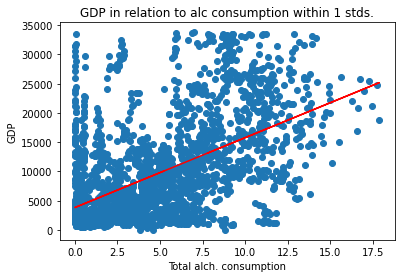

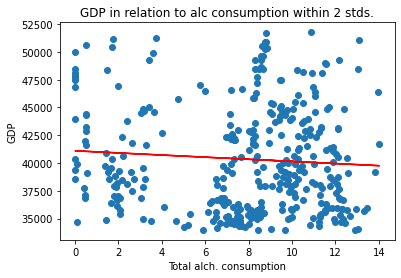

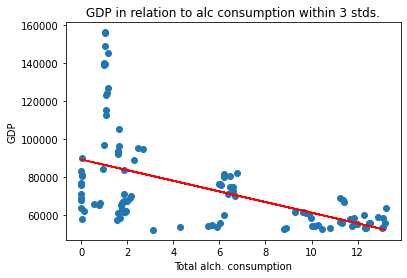

In [35]:
figures = []
for i in range(1,4):
    fig, ax = plt.subplots()
    figures.append((fig,ax))

    #within
    gdp = data_analysis['gdp_pc_2011_mb']

    upper_max = mean_gdp + (std_gdp*i)
    lower_max = mean_gdp + (std_gdp*(i-1))
    lower_min = mean_gdp - (std_gdp*i)
    upper_min = mean_gdp - (std_gdp*(i-1))

    if i != 3:
        payFocus1 = data_analysis[(data_analysis['gdp_pc_2011_mb'] >= lower_max) & (data_analysis['gdp_pc_2011_mb'] <= upper_max)]
        payFocus2 = data_analysis[(data_analysis['gdp_pc_2011_mb'] >= lower_min) & (data_analysis['gdp_pc_2011_mb'] <= upper_min)]
    else:
        payFocus1 = data_analysis[(data_analysis['gdp_pc_2011_mb'] >= lower_max)]
        payFocus2 = data_analysis[(data_analysis['gdp_pc_2011_mb'] <= upper_min)]

    payFocus = pd.concat([payFocus1,payFocus2])
    m, b = np.polyfit(payFocus['total_consumption'],payFocus['gdp_pc_2011_mb'],1)
    figures[i-1][1].plot(payFocus['total_consumption'],m*payFocus['total_consumption']+b,color='red')
    figures[i-1][1].scatter(payFocus['total_consumption'],payFocus['gdp_pc_2011_mb'])
    figures[i-1][1].set_xlabel(f'Total alch. consumption')
    figures[i-1][1].set_ylabel("GDP")
    figures[i-1][1].set_title(f"GDP in relation to alc consumption within {i} stds.")

Hmm...interesting it would look like our intuition might be right.  For average GDP it would appear that alch. consumption has a positive correlation, but for the rags and riches zones, the less alchohol, the higher the GDP.  

<center>
    <h3>Conclusion</h3>
</center>

Based on our evaluation and analysis, average GDP and alcohol consumption has a positive correlation. This indicates that for the majority of countries, the alcohol consumption of their citizens does not impede their productivity and is actually beneficial to a country. We also found that there is a positive correlation between beer, wine, and spirit consumption and GDP while there is a negative correlation between other alcoholic drink consumption and GDP. 

Another interesting observation that we found was the GDP vs alcohol consumption in standard deviations. What we found was that countries with GDP in one standard deviation had a positive correlation with alcohol consumption. However, countries with GDP of two and three standard deviations had a negative correlation with alcohol consumption. This means that countries that are either very wealthy or very poor may drink less alcohol on average. For poor countries, it makes sense as their citizens may not have the finances to buy alcohol but for wealthy countries this is surprising. This could indicate that wealthy countries don't drink as much alcohol thus making their citizens more productive.

If anything this tutorial should show you that alcohol consumption in a country is not immediatly a bad thing.

The CSV and DTA files that are used in this tutorial are avalibale on <a href = "https://github.com/evanamay/CMSC320-Final-Project">GitHub</a>


<hr>